In [30]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

In [31]:
def softmax(fc, gain=4, axis=1):
    # First normalize the fc values.
    # Make it's standart deviation 1. And mean 0.
    fc = fc - np.mean(fc, axis=axis, keepdims=True)
    fc = fc / (1e-37+np.std(fc, axis=axis, keepdims=True))

    fc = fc - np.max(fc, axis=axis, keepdims=True)
    return np.exp(gain * fc) / np.sum(np.exp(gain * fc), axis=axis, keepdims=True)

def linear_map(x, a, b):
    return a + (b - a) * (x - np.min(x)) / (np.max(x) - np.min(x))

def std(p, t):
    u = np.sum(p * t, axis=1, keepdims=True)
    return np.sqrt(np.sum(p * (t - u)**2, axis=1, keepdims=True))

def entropy(p):
    return -np.sum(p * np.log(p + 1e-37), axis=1)

def gaussian(x, mu, sig, axis=1):
    g = np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    return g / np.sum(g, axis=axis, keepdims=True)

def detection_probability(cov, window_size=5):
    ts = np.shape(cov)[1]
    t = np.expand_dims(np.linspace(-15, 15, ts), axis=0)
    
    p = softmax(cov)

    tu = np.sum(p * t, axis=1, keepdims=True)
    g = gaussian(t, np.zeros_like(0), window_size*np.ones_like(t))
    
    return np.sum(cov * g, axis=1)

def detection_probability_ensemble(cov, window_size=2.5):
    # (BATCH_SIZE, N_ENSEMBLE, N_TIMESTEPS)
    ts = np.shape(cov)[2]
    t = np.expand_dims(np.expand_dims(np.linspace(-15, 15, ts), axis=0), axis=0)

    p = softmax(cov, axis=2)
    tu = np.sum(p * t, axis=2, keepdims=True)

    g = gaussian(t, tu, window_size*np.ones_like(t), axis=2)

    return np.mean(np.sum(cov * g, axis=(2)), axis=1)

def batch_normalize_feature(f):
    # Demean each channel over time axes.
    f = f - np.mean(f, axis=(1), keepdims=True)
    
    # Normalize each channel by dividing it to standart deviation.
    f = f / np.sqrt(np.mean(np.square(f), axis=(0, 1), keepdims=True))

    return f

def plot_violin(df_traces, metric):
    plt.clf()
    plt.figure(figsize=(10, 8))
    sns.violinplot(x=df_traces["label"], y=df_traces[metric], data=df_traces, linewidth=0.5)

def print_maxf1_metrics(metrics):
    max_f1_score_idx = np.argmax(metrics["f1_score"])
    print({"acc":metrics["acc"][max_f1_score_idx],
           "pre":metrics["pre"][max_f1_score_idx],
           "rec":metrics["rec"][max_f1_score_idx],
           "f1_score":metrics["f1_score"][max_f1_score_idx]})
    
def plot_density(df_traces, metric, fname):
    plt.clf()
    plt.figure(figsize=(10, 8))
    sns.kdeplot(data=df_traces, hue="Type", hue_order=["earthquake", "noise"], x=df_traces[metric], bw_adjust=0.25)
    plt.savefig("density_{}.pdf".format(fname), bbox_inches='tight')
    
def plot_roc(models):
    plt.clf()
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_ylim([0, 1])
    for model in models:
        ax.plot(model["fpr"],  model["tpr"], label =model["name"])
    
    ax.legend()
    plt.savefig("roc.pdf", bbox_inches='tight')

def plot_prerec(models):
    plt.clf()
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    
    for model in models:
        ax.plot(model["rec"],  model["pre"], label =model["name"])
    
    ax.legend()

def plot_waveform(x, spec, title, t, x_axis_label="", xaxis_loc="center"):
    shapex = np.shape(x)
    if len(shapex) == 1:
        channels = 1
        x = np.expand_dims(x, axis=1)
    else:
        channels = shapex[1]

    waveforms = gridspec.GridSpecFromSubplotSpec(
        channels,
        1,
        subplot_spec=spec,
        wspace=0.3,
        hspace=0.1,
    )

    for i in range(channels):
        ax = plt.subplot(waveforms[i, 0])
        if i == 0:
            ax.set_title(title, loc="left")
        
        if i == channels - 1:
            ax.set_xlabel(x_axis_label, loc=xaxis_loc)


        ax.plot(t, x[:, i], linewidth=0.5)

def plot_feature(x, spec, title, x_axis_vis=True, x_axis_label="", y_axis_vis=True, y_axis_label="", xaxis_loc="center", yaxis_loc="center"):
    ax = plt.subplot(spec)
    ax.set_xlabel(x_axis_label, loc=xaxis_loc)
    ax.set_ylabel(y_axis_label, loc=yaxis_loc)
    #ax.xaxis.set_visible(x_axis_vis)
    ax.yaxis.set_visible(y_axis_vis)

    ax.set_xticklabels(["", "0", "30", "60"])
    ax.set_yticklabels(["", "64", "0"])

    ax.set_title(title, loc="left")
    ax.imshow(np.transpose(x), cmap="gray", interpolation='nearest')

def plot_ae_sample(latent_cov, waveforms=[], features=[]):
    gs_main = gridspec.GridSpec(3, 1, wspace=0.5, hspace=0.5, height_ratios=[2, 2, 1])
    gs_waveform = gridspec.GridSpecFromSubplotSpec(1, len(waveforms), gs_main[0, 0], wspace=0.5, hspace=0.5)
    gs_representations = gridspec.GridSpecFromSubplotSpec(1, len(features), gs_main[1, 0], wspace=0.5, hspace=0.5)
    gs_covariance = gs_main[2, 0]

    labels = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)"]
    label_idx = 0
    plot_waveform(waveforms[0], gs_waveform[0], labels[label_idx], t=np.linspace(0, 30, 3000))
    label_idx += 1
    if len(waveforms) > 1:
        plot_waveform(waveforms[1], gs_waveform[1], labels[label_idx], t=np.linspace(0, 30, 3000))
    label_idx += 1
    for i, feature in enumerate(features):
        if i > 0:
            plot_feature(feature, gs_representations[i], "{}".format(labels[label_idx]), y_axis_vis=False)
        else:
            plot_feature(feature, gs_representations[i], "{}".format(labels[label_idx]))

        label_idx += 1

    plot_waveform(latent_cov, gs_covariance, labels[label_idx], t=np.linspace(-15, 15, 94))

def is_test_sample(df):
    df["min_crop_offset"] = df["p_arrival_sample"] + 300 - 3000
    df["max_crop_offset"] = df["p_arrival_sample"] - 300

    return ((df["min_crop_offset"] < df["crop_offset"]) & ((df["crop_offset"] < df["max_crop_offset"])))

def drop_ill_crops(df_traces):
    # Reset traces index.
    df_traces.reset_index(inplace=True)
    df_eq = df_traces[df_traces.label == "eq"]
    df_no = df_traces[df_traces.label == "no"]

    # Eliminate ill cropped traces.
    df_eq = df_eq[is_test_sample(df_eq)]

    # Concat eq and no traces. And shuffle them. 
    df_traces = pd.concat([df_eq, df_no], ignore_index=False)
    df_traces = df_traces.sample(frac=1)

    return df_traces

In [32]:
exps = [{"name":"autocovaraince_detector_30s_for_plots",
        "traces_path": "../results/autocovaraince_detector_30s_for_plots/training_instance/testing_instance/AutocovarianceMonitor30s/split0/traces_nbatches1.csv",
        "monitor_path": "../results/autocovaraince_detector_30s_for_plots/training_instance/testing_instance/AutocovarianceMonitor30s/split0/epoch19_monitoredparams['x', 'f', 'fcov'].hdf5"
     }]

curves = []
traces = []
for exp in exps:
    df_traces = pd.read_csv(exp["traces_path"])

    with h5.File(exp["monitor_path"], "r") as f:
        fcov = np.array(f["fcov"])

    df_traces = drop_ill_crops(df_traces)
    
    fcov = fcov[np.array(df_traces.index), :]
    print(np.shape(fcov))
    df_traces["Cross-covariance"] = detection_probability(fcov)
    
    #df_traces["Cross-covariance"] = np.max(fcov, axis=1)*94
    traces.append(df_traces)

    fpr, tpr, thresholds = roc_curve(df_traces["label"] == "eq", df_traces["Cross-covariance"])
    pre, rec, thresholds = precision_recall_curve(df_traces["label"] == "eq", df_traces["Cross-covariance"])
    print(auc(fpr, tpr))
    curves.append({"fpr": fpr, "tpr": tpr, "pre": pre, "rec": rec, "name": exp["name"]})

(220, 94)
0.9124561403508771


/tmp/ipykernel_316661/277737275.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["min_crop_offset"] = df["p_arrival_sample"] + 300 - 3000
/tmp/ipykernel_316661/277737275.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["max_crop_offset"] = df["p_arrival_sample"] - 300


<Figure size 640x480 with 0 Axes>

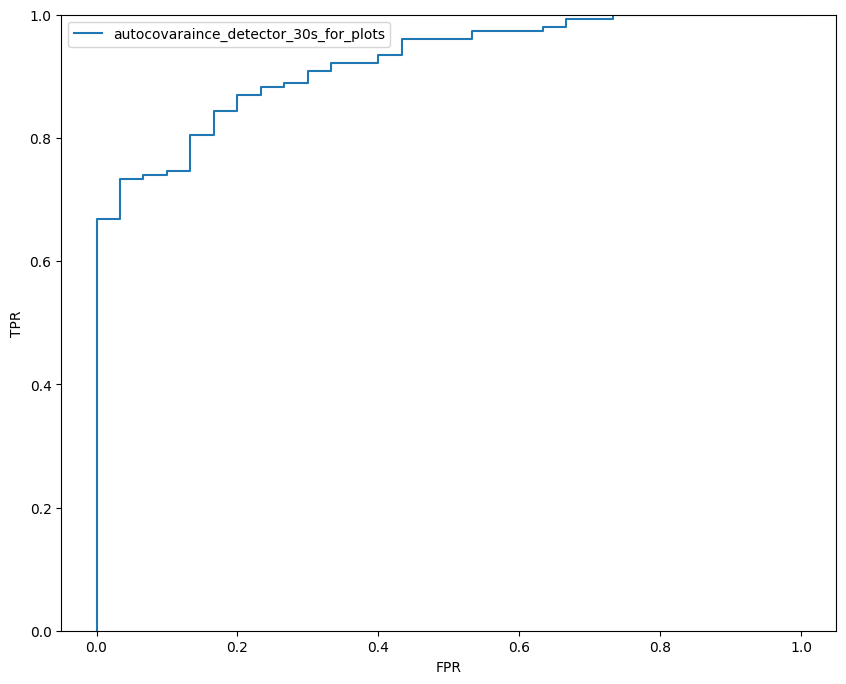

In [13]:
plot_roc(curves)

<Figure size 640x480 with 0 Axes>

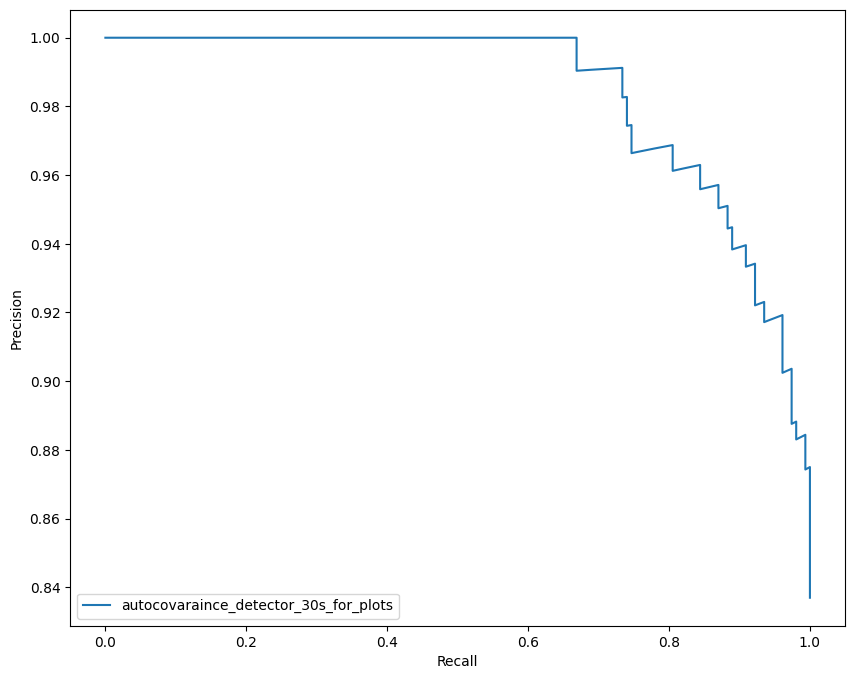

In [14]:
plot_prerec(curves)

In [33]:
import random
with h5.File(exps[-1]["monitor_path"], "r") as fil:
    fcov = np.array(fil["fcov"])
    f = np.array(fil["f"])
    x = np.array(fil["x"])

/tmp/ipykernel_316661/277737275.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0", "30", "60"])
/tmp/ipykernel_316661/277737275.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "64", "0"])


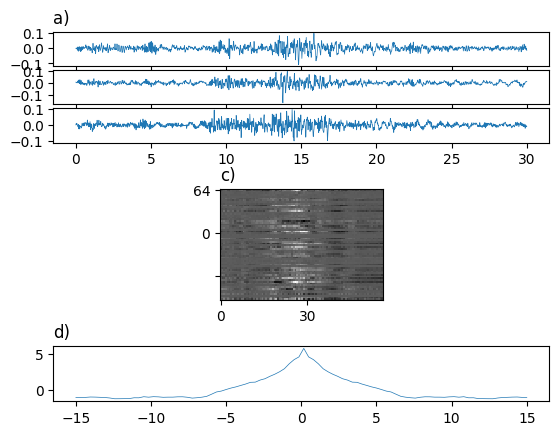

In [90]:
sample_idx = random.randint(0, len(fcov))

plot_ae_sample(fcov[sample_idx], [x[sample_idx]], [f[sample_idx]])
plt.savefig("../figs/ensemble_mean.pdf", dpi=600)

<Figure size 640x480 with 0 Axes>

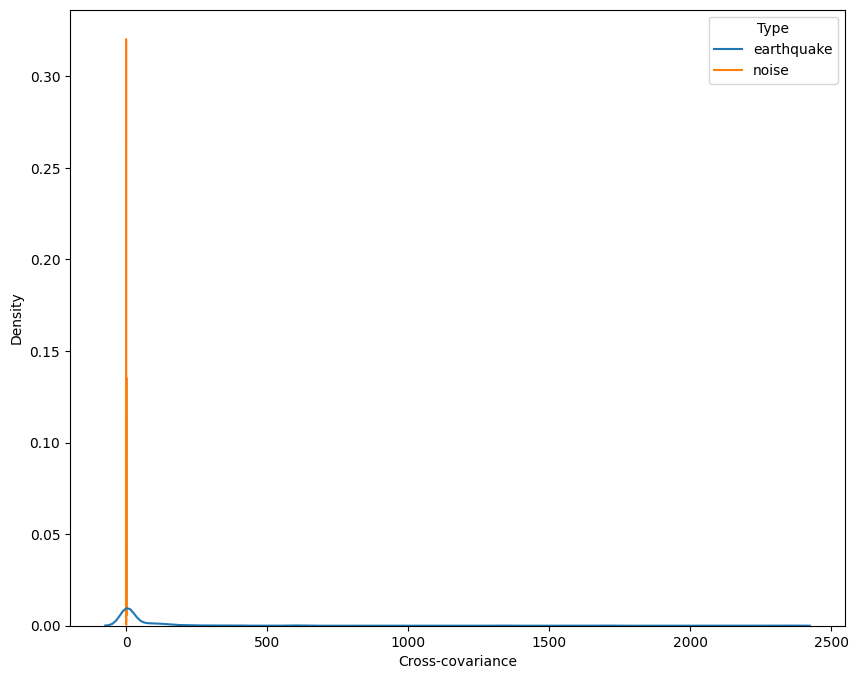

In [17]:
for trace_idx, trace in enumerate(traces):
    trace.loc[trace["label"] == "eq", "label"] = "earthquake"
    trace.loc[trace["label"] == "no", "label"] = "noise"
    trace.rename(columns={"label": "Type"}, inplace=True)
    plot_density(trace, "Cross-covariance", trace_idx)